# CSCI 3360 : Handwritten Digit Data Clustering
In this assignment, we are going to apply $k$-means clustering method to the handwritten digit dataset, called **MNIST**, to group similar images of digits together. The mnist dataset contains $28\times 28$ pixel images of handwritten digits 0 through 9. The training set and test set contain 60,000 and 10,000 examples, respectively.

## Submission instruction
- Due by 11:59pm on **April 24th, 2017**
- Complete this notebook and submit it by the due date
- Do not use any 3rd party libraries unless you are asked to do so.
- Feel free to define your own functions if needed.


## Task 0: load the mnist dataset
First, you can download the dataset from [here](http://yann.lecun.com/exdb/mnist/). Visit the website and download the four files:
- train-images-idx3-ubyte
- train-labels-idx1-ubyte
- t10k-images-idx3-ubyte
- t10k-labels-idx1-ubyte

You can use the following code to load the MNIST data. Probably, it is going to take longer than the files you tried in the past assignment.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import struct
import os
import math
import random
import time

In [2]:
def load_data(dataset="train", path="/Users/syheedahmed/Desktop/"):
    """
    Parameters:
    ------------
      - dataset: a string either 'train' or 'test'
      - path: path to the directory where data files exist
      
    Returns:
      - X, y: paired (features, labels) dataset
    """
    if dataset == "train":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset == "test":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be either 'test' or 'train'")
    
    # load features
    fimg = open(fname_img, 'rb')
    magic,size = struct.unpack('>ii', fimg.read(8))
    sx,sy = struct.unpack('>ii', fimg.read(8))
    img = []
    for i in range(size):
        im =  struct.unpack('B'*(sx*sy), fimg.read(sx*sy))
        img.append([float(x)/255.0 for x in im])
    
    fimg.close()
    X = np.array(img)
    
    # load labels
    flbl = open(fname_lbl, 'rb')
    magic,size = struct.unpack('>ii', flbl.read(8))
    lbl = struct.unpack('B'*size, flbl.read(size))
    
    flbl.close()
    y = np.array(lbl)
    
    return X, y

In [4]:
# load the dataset
X_train, y_train = load_data("train")
X_test, y_test = load_data("test")

print "training set of size ", X_train.shape
print "test set of size ", X_test.shape

training set of size  (60000, 784)
test set of size  (10000, 784)


After loading the dataset, you can use the following code to display some examples in the data.

In [5]:
def plot_digit(digit, label):
    """ 
    Display an image of digit
    Parameters
    ------------------
     - digit: numpy array of length 28 x 28 = 784
     - label: an integer corresponding to the label
    """
    
    image = digit.reshape(28, 28)
    
    plt.imshow(image, cmap='gray_r', interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    
    plt.title("Label: " + str(label))

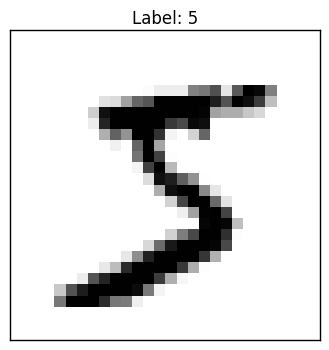

In [6]:
# display the first image in the training set
plot_digit(X_train[0], y_train[0])

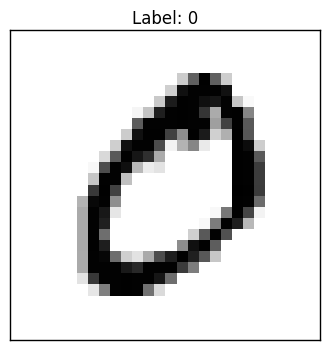

In [7]:
plot_digit(X_train[1], y_train[1])

# Task 1: implement k-means algorithm
Now, we are ready to implement our k-means algorithm. Please recall that k-means consists of two steps. At each iteration, the algorithm
- assigns the data points to its nearest cluster centroid and then
- updates cluster centroids based on the new assignment.

We can measure the goodness of the given clustering by computing **within-cluster-sum-of-squares (WCSS)**, which is defined as:
$$
\text{WCSS}(C) = \sum_{i=1}^K \sum_{x \in C_i} \| x - \mu_i\|^2\,,
$$
where $\mu_i$ is the center of $i^{\text{th}}$ cluster $C_i$.

Implement the $k$-means algorithm using the following template. Feel free to add more member functions if you need.

In [8]:
print X_train.shape

print y_train


(60000, 784)
[5 0 4 ..., 5 6 8]


In [9]:
class MyKMeans:
    def __init__(self, k):
        """
        Parameters:
          - k: number of partitions (or clusters)
        """
        self.K = k
        self.centers = None

    def initialize_centers(self, X):
        """ 
        initialize the k-centeroids (self.centers) with randomly chosen points
        
        Parameters:
         - k : number of clusters
         - dim: dimensionality of each centroid
        """
        k = self.K
        centers = []

        # select k random datapoints (np array) from dataset
        random.seed(9001) 
        # consider loop comprehension*
        # centers = [random.randint for]
        for _ in range(k):
            centers.append(X[random.randint(0, len(X))])
        
        self.centers = centers
    
    def assign_points(self, X):
        """ 
        This function assigns data points to their nearest centroids.
        
        Parameters:
         - X: 2D array of examples, each row is an example.
        
        returns:
         - assignment: a list of cluster assignment. Each element in this list corresponds to 
                  the index of cluster to which the given data point is assigned.
                  For example, labels=[0, 1, 1, ...] means that the first example in X was
                  assigned to the first cluster, the second example to the 2nd cluster, and 
                  so on.
        """


        assignment = []
        dist = []
        
        # loop through each centroid for each X
        for x in X:
            temp = []
            for center in self.centers:
                temp.append(np.linalg.norm(center-x))
            dist.append(temp)
        
        # return the index of the least distance of each element in list
        for d in dist:
            assignment.append(d.index(min(d)))
        


        
        return assignment
    
    def update_mean(self, X, assignment):
        """ 
        Given the current cluster assignment, this function recomputes the mean (the centroid) of 
        each cluster.
        
        Parameters:
         - X: 2D array of examples
         - assignment: cluster assignment for all examples
        """
        
        # categorize all X's by assigmnet
        clusters = [[] for _ in range(self.K)]
        
        # create array of clusters based on their assignments
        for i, x in zip(assignment, X):
            clusters[i].append(x)
    
        
        # sum them and divide by n of items 
        centroids = [np.mean(cluster, axis=0) for cluster in clusters]
        
        
        # these are the new means
        self.centers = centroids
        
        return clusters
    
    def compute_WCSS(self,  X):
        """
        compute the within-cluster-sum-of-squares
        
        Parameters:
         - X: 2D array of examples
         
        Retrurn:
         - wcss: a real number
        """
        
        wcss = 0
        for i, centroid in zip(range(len(self.centers)),self.centers):
            for x in X[i]:
                wcss = wcss + np.linalg.norm(x - centroid)

        
        return wcss
    
    def fit(self, X, max_iter=20):
        """ 
        trains the k-means model using the given dataset. This function will call assign_points()
        and update_mean(
        ) functions in a loop
        
        Parameters
        ------------
        - X: 2D numpy array, each row represents an example
        - max_iter: an integer, maximum number of iterations to run
                
        """
        wcss = 0
        errors = []
        for i in range(max_iter):
            print 'Iteration',i
            
            # list of each x's cluster number
            assignments = km.assign_points(X)

            # calculates new centroids(means)
            clusters = km.update_mean(X, assignments)
            
            # stop loop if there's no change
            if abs(wcss-km.compute_WCSS(clusters)) <= 0.1:
                print 'Optimal found in',i,'iterations'
                break
                
            wcss = km.compute_WCSS(clusters)
            errors.append(wcss)
            print 'WCSS =',wcss
            
        return clusters, errors

Using the k-means algorithm you implemented above, we can cluster images of digits into $k$-groups. Obviously, we have 10 clusters (or classes), but we are going to set $k$ greater than 10 (for example, let's say $k=15$). (why?)

## Task 2: Run k-means and Visualize the centroids
Run the k-means algorithm 10 times and choose the one with the smallest WCSS. Visualize the $k$-centroids. Note that the centroid is average of images in that cluser, which is still a image but it will be blurry due to the averaging.

In [12]:
k = 3
km = MyKMeans(k)
km.initialize_centers(X_train)

print len(km.assign_points(X_train)) , len(X_train)
print km.assign_points(X_train)


60000 60000
[0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 1, 2, 0, 2, 2, 1, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 1, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 1, 0, 2, 0, 2, 0, 2, 1, 2, 1, 2, 0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 2, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1, 1, 0, 2, 0, 1, 1, 2, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 1, 0, 2, 0, 2, 0, 2, 0, 1, 2, 2, 0, 2, 0, 0, 0, 0, 2, 1, 2, 0, 2, 2, 0, 0, 0, 1, 0, 1, 0, 1, 1, 2, 1, 0, 1, 0, 2, 0, 1, 1, 0, 0, 2, 0, 2, 2, 1, 1, 2, 0, 0, 2, 0, 0, 0, 2, 1, 2, 2, 0, 1, 0, 1, 2, 0, 0, 2, 1, 0, 2, 2, 0, 0, 2, 1, 0, 2, 0, 0, 2, 0, 1, 0, 2, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 2, 0, 0, 0, 2, 2, 0, 1, 1, 0, 0, 1, 0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 2, 1, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 1, 1, 0, 0, 1, 2, 1, 0, 0, 2, 1, 0, 1, 0, 2, 0, 0, 0, 1, 2, 2, 0, 1, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 1, 2, 0, 0, 0, 2, 1, 2, 0, 1, 2, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 

Iteration 0
WCSS = 385799.441211
Iteration 1
WCSS = 374736.660972
Iteration 2
WCSS = 368383.431898
Iteration 3
WCSS = 364428.365897
Iteration 4
WCSS = 362017.266415
Iteration 5
WCSS = 360629.306329
Iteration 6
WCSS = 359828.038545
Iteration 7
WCSS = 359320.851421
Iteration 8
WCSS = 358945.312199
Iteration 9
WCSS = 358629.13872
Iteration 10
WCSS = 358401.974672
Iteration 11
WCSS = 358245.348285
Iteration 12
WCSS = 358109.170472
Iteration 13
WCSS = 357990.320424
Iteration 14
WCSS = 357887.921637


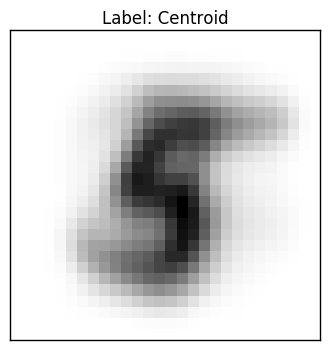

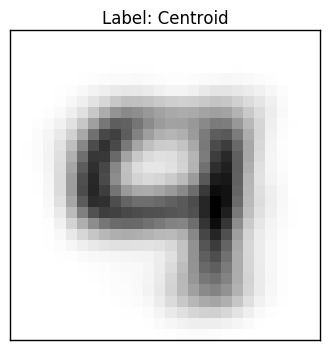

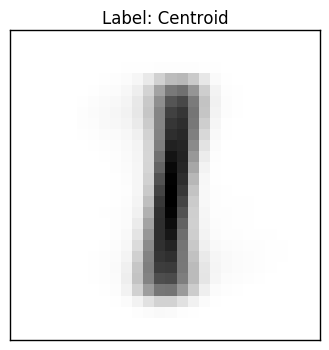

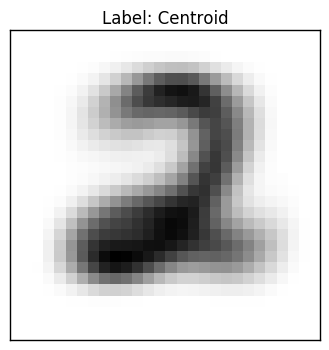

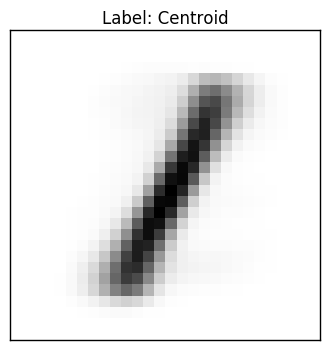

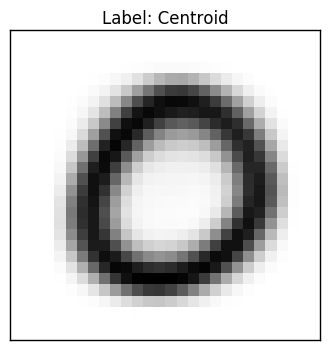

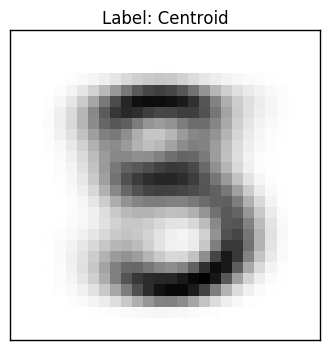

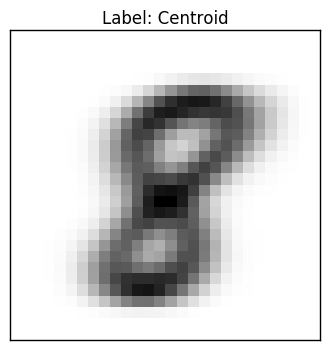

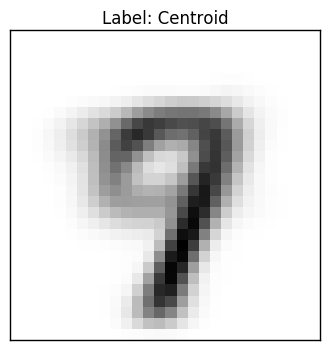

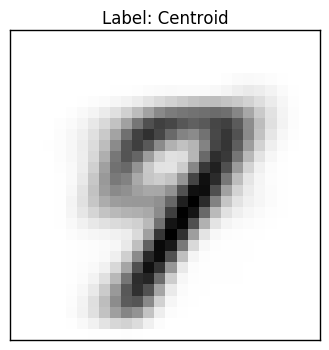

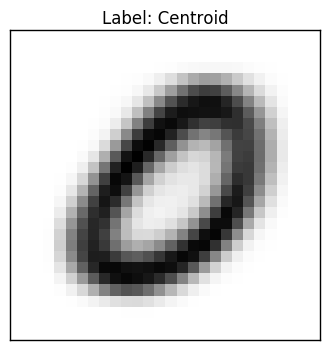

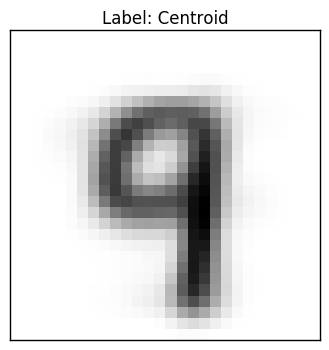

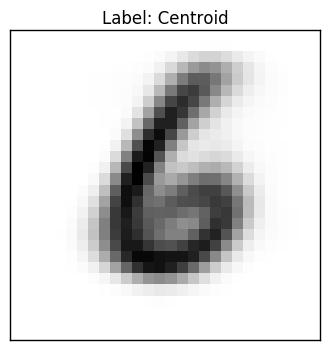

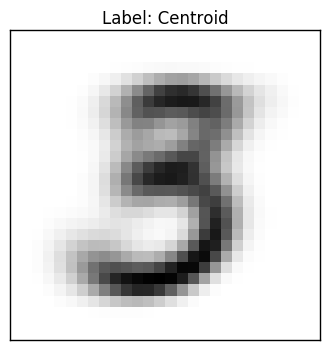

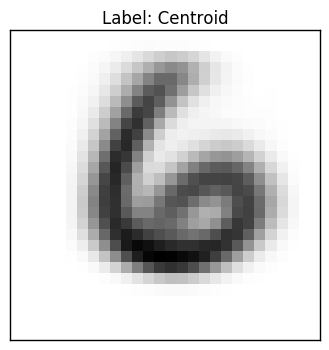

In [89]:
# running 10 times is not feasible 

k = 15

km = MyKMeans(k)

# run k-means 10 times and choose the one that gives you the best results, i.e.,
# one with the smallest WCSS

#------------------------------#
#  Your code goes here         #
#------------------------------#

# initialize centroids
km.initialize_centers(X_train)


clusters,errors = km.fit(X_train, k)

# visualize centroids
for center in km.centers:
    plot_digit(center, "Centroid")
    plt.show()


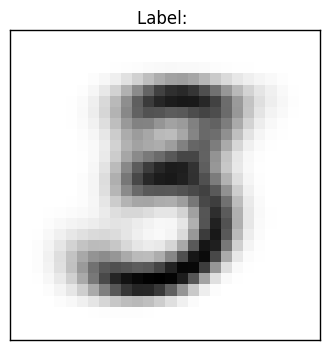

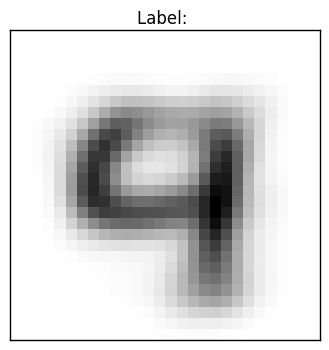

In [90]:
# first: 385799.441211
# 2nd: 374736.660972
# ...
# 2nd to last: 358945.312199
# last (max_iter=10):358629.13872


## Task 3: Classification
After running the k-means, you get the clustering results consisting of $k$-centroid and indices of data points belonging to each cluster. Determine its label as the majority of labels in the cluster. Once we determine the labels for $k$-centroids, we can use this to classify data points.

For each example $(x_i, y_i)$ in the test set **X_test**, 
1. find the nearest centroid of $x_i$
2. predict the label of $x_i$, $y_i'$ as that of its nearest centroid
3. compute the accuracy by counting the number of examples with $y_i = y_i'$

For this task, implement the following function.

In [91]:
def assigning_label(centers, y, assignment):
    """
    determines the label of each cluster by looking at the labels of its members
    
    Parameters:
     - centers: k-centroids
     - y: true label in the dataset
     - assignment: a list (or array) representing the assignments of data points to clusters
    
    Returns:
     - labels: an array of length k, labels for clusters
    """
    clusters = [[] for _ in range(len(centers))]
    
    for y_i, ass_i in zip(y, assignment):
        clusters[ass_i].append(y_i)
    
    return [np.argmax(np.bincount(cluster)) for cluster in clusters]
    

In [92]:
assignments_test = km.assign_points(X_test)


print 'Cluster labels:',assigning_label(km.centers,y_test,assignments_test)

Cluster labels: [5, 4, 1, 2, 1, 0, 3, 8, 7, 7, 0, 9, 6, 3, 6]


**Report the best accuracy you obtained.**

**Visualize the followings for $i=5, 10, 15$:**
1. test image, i.e., $x_i$ (for this use the plot_digit() function)
2. its nearest centroid
3. its true label $y_i$
4. its predicted label $y_i'$

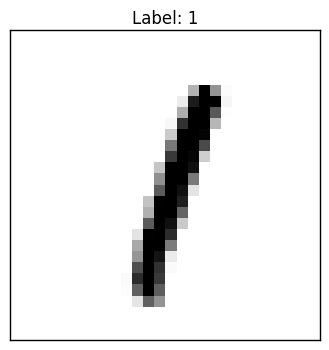

Nearest centroid: 4
True: 1
Predicted: 1


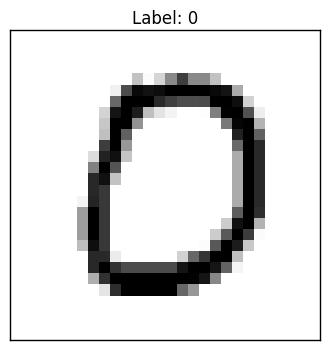

Nearest centroid: 5
True: 0
Predicted: 0


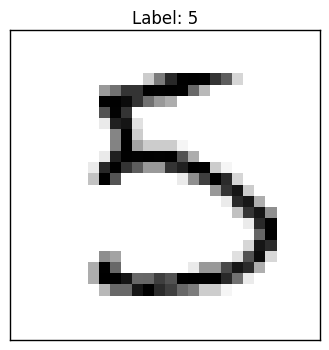

Nearest centroid: 6
True: 5
Predicted: 3


In [93]:
assignment = km.assign_points(X_test)

for i in [5,10,15]:

    # 1
    plot_digit(X_test[i], y_test[i])
    plt.show()

    # 2
    print 'Nearest centroid:', assignment[i]

    # 3
    print 'True:', y_test[i]

    # 4
    print 'Predicted:', assigning_label(km.centers,y_test,assignment)[assignment[i]]


## Task 4:Plots to draw

1. Set $k=15$, and draw a plot that shows how the objective value of $k$-means, WCSS, changes with iterations.
2. For $k = [5, 10, 15, 20, 25]$, train the k-means model using the examples in the training set and compute its accuracy on the test set. Draw a plot showing how the classification accuracy of $k$-means changes as you change the value of $k$. The $x$-axis and $y$-axis corresponds to $k$ and accuracy, respectively.


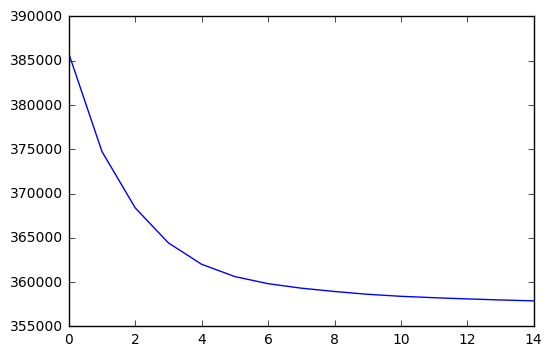

'\n#2\nk = 1\n\nkm = MyKMeans(k)\n\n# initialize centroids\nkm.initialize_centers(X_train)\n\nclusters,errors = km.fit(X_train, k)\n\nassignment = km.assign_points(X_test)\n\naccurate = []\n\n[accurate.append(assigning_label(km.centers,y_test,assignment)[assignment[i]] == y_test[i]) for i in range(len(X_test[:10]))]\n\naccurate = np.array(accurate)\nprint accurate.count_nonzero(x == 0)\n\nprint accurate.count_nonzero(x == 1)\n'

In [94]:
# 1
x = range(len(errors))
# WCSS Values Plot
plt.plot(x,errors)
plt.show()

'''
#2
k = 1

km = MyKMeans(k)

# initialize centroids
km.initialize_centers(X_train)

clusters,errors = km.fit(X_train, k)

assignment = km.assign_points(X_test)

accurate = []

[accurate.append(assigning_label(km.centers,y_test,assignment)[assignment[i]] == y_test[i]) for i in range(len(X_test[:10]))]

accurate = np.array(accurate)
print accurate.count_nonzero(x == 0)

print accurate.count_nonzero(x == 1)
'''
 
